In [157]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import tqdm


In [208]:
from scipy.signal import butter, filtfilt
from scipy import signal
import random



class QuakeData:

    def __init__(self,
                 chunk_data=False,
                 window_size=1000,
                 window_step_size=100,
                 window_deadzone=200,
                 downsample_data=False,
                 downsample_hz=6.625,
                 normalize_data=False,
                 normalize_method='z-score',
                 use_gauss_labels=False,
                 gauss_factor=0.5,
                 use_neg_one_for_deadzone=False
            ):
        self.train_data = {}
        self.test_data = {}

        self.chunk_data = chunk_data
        self.window_size = window_size
        self.window_step_size = window_step_size
        self.window_deadzone = window_deadzone

        self.normalize_data = normalize_data
        self.normalize_method = normalize_method
        assert self.normalize_method in {'z-score'}

        self.use_gauss_labels = use_gauss_labels
        self.gauss_factor = gauss_factor
        
        self.use_neg_one_for_deadzone = use_neg_one_for_deadzone

        self.train_data['lunar'] = []
        self.train_data['mars'] = []
        self.train_data['earth'] = []
        self.train_indices = []

        self.test_data['lunar'] = []
        self.test_data['mars'] = []
        self.test_indices = []

        base_data_path = "./space_apps_2024_seismic_detection/data/"
        
        lunar_cat_path = os.path.join(base_data_path, "lunar", "training", "catalogs", 'apollo12_catalog_GradeA_final.csv')
        lunar_data_path = os.path.join(base_data_path, "lunar", "training", "data", "S12_GradeA")

        lunar_files = self.process_cat_file(lunar_cat_path, lunar_data_path)
        l = [x['mseed_path'] for x in lunar_files]
        assert len(l) == len(set(l))
        for x in tqdm.tqdm(lunar_files):
            x_stats, x_t, x_v = self.read_mseed(x['mseed_path'])


            if downsample_data:
                x_t, x_v = self.downsample_data(x_t, x_v, x_stats, hz=downsample_hz)

            label_arr = np.zeros_like(x_t)
            i = np.abs(x_t - x['label']).argmin()
            label_arr[i] = 1
            
            self.train_data['lunar'].append({
                'stats':x_stats,
                'values':x_v,
                'times':x_t,
                'label':x['label'],
                'label_arr':label_arr
            })

        for file_index, x in enumerate(self.train_data['lunar']):
            n = len(x['values'])

            if self.chunk_data:
                for i in range(0, n-window_size, window_step_size):
                    self.train_indices.append(('lunar', file_index, i))
            else:
                self.train_indices.append(('lunar', file_index, 0))


        mars_cat_path = os.path.join(base_data_path, "mars", "training", "catalogs", 'Mars_InSight_training_catalog_final.csv')
        mars_data_path = os.path.join(base_data_path, "mars", "training", "data")
        mars_files = self.process_cat_file(mars_cat_path, mars_data_path)
        l = [x['mseed_path'] for x in mars_files]
        assert len(l) == len(set(l))
        for x in tqdm.tqdm(mars_files):
            x_stats, x_t, x_v = self.read_mseed(x['mseed_path'])

            if downsample_data:
                x_t, x_v = self.downsample_data(x_t, x_v, x_stats, hz=downsample_hz)

            label_arr = np.zeros_like(x_t)
            i = np.abs(x_t - x['label']).argmin()
            label_arr[i] = 1

            print(len(x_v))

            self.train_data['mars'].append({
                'stats':x_stats,
                'values':x_v,
                'times':x_t,
                'label':x['label'],
                'label_arr':label_arr
            })

        for file_index, x in enumerate(self.train_data['mars']):
            n = len(x['values'])

            if self.chunk_data:
                for i in range(0, n-window_size, window_step_size):
                    self.train_indices.append(('mars', file_index, i))
            else:
                self.train_indices.append(('mars', file_index, 0))



        lunar_test_root = os.path.join(base_data_path, "lunar", "test")
        for mseed_path in self.get_all_mseed(lunar_test_root):
            x_stats, x_t, x_v = self.read_mseed(mseed_path)

            if downsample_data:
                x_t, x_v = self.downsample_data(x_t, x_v, x_stats, hz=downsample_hz)

            self.test_data['lunar'].append({
                'stats':x_stats,
                'values':x_v,
                'times':x_t
            })

        for file_index, x in enumerate(self.test_data['lunar']):
            n = len(x['values'])

            if self.chunk_data:
                for i in range(0, n-window_size, window_step_size):
                    self.test_indices.append(('lunar', file_index, i))
            else:
                self.test_indices.append(('lunar', file_index, 0))

        mars_test_root = os.path.join(base_data_path, "mars", "test")
        for mseed_path in self.get_all_mseed(mars_test_root):
            x_stats, x_t, x_v = self.read_mseed(mseed_path)

            if downsample_data:
                x_t, x_v = self.downsample_data(x_t, x_v, x_stats, hz=downsample_hz)

            self.test_data['mars'].append({
                'stats':x_stats,
                'values':x_v,
                'times':x_t
            })

        for file_index, x in enumerate(self.test_data['mars']):
            n = len(x['values'])

            if self.chunk_data:
                for i in range(0, n-window_size, window_step_size):
                    self.test_indices.append(('mars', file_index, i))
            else:
                self.test_indices.append(('mars', file_index, 0))

        base_earth_dir = "./earth_train_data/"
        for f_name in tqdm.tqdm(os.listdir(base_earth_dir)):
            f_path = os.path.join(base_earth_dir, f_name)
            x_stats, x_t, x_v = self.read_mseed(f_path)

            if downsample_data:
                x_t, x_v = self.downsample_data(x_t, x_v, x_stats, hz=downsample_hz)

            label_arr = np.zeros_like(x_t)
            i = np.abs(x_t - 3000).argmin()
            label_arr[i] = 1

            #print(x_t[0], x_t[-1])

            self.train_data['earth'].append({
                'stats':x_stats,
                'values':x_v,
                'times':x_t,
                'label':3000,
                'label_arr':label_arr
            })

        for file_index, x in enumerate(self.train_data['earth']):
            n = len(x['values'])

            if self.chunk_data:
                for i in range(0, n-window_size, window_step_size):
                    self.train_indices.append(('earth', file_index, i))
            else:
                self.train_indices.append(('earth', file_index, 0))

    
    def add_synthetic_data(self, num_pos=100):
        #train_indices.append(('lunar', file_index, 0))

        x = {}
        k_f_l = set()
        
        for i, (key, file_index, _) in enumerate(self.train_indices):
            if key not in {'mars', 'lunar'}:
                continue

            if key not in x:
                x[key] = {}
            if file_index not in x[key]:
                x[key][file_index] = {'pos':[], 'neg':[]}

            _, _, has_sample, has_sample_at_all = self.get_train_sample(i)

            if has_sample:
                x[key][file_index]['pos'].append(i)
            elif not has_sample_at_all:
                x[key][file_index]['neg'].append(i)

            k_f_l.add((key, file_index))
        # random select key/fileindex
        # random select pos case to add to a random neg case
        # repeat

        for k in x:
            for f in x[k]:
                print(k, f, len(x[k][f]['pos']), len(x[k][f]['neg']))

        k_f_l = list(k_f_l)

        self.train_data['synthetic'] = []
        for i in tqdm.tqdm(range(num_pos)):
            key, file_index = random.choice(k_f_l)

            pos_i = random.choice(x[key][file_index]['pos'])
            neg_i = random.choice(x[key][file_index]['neg'])

            x_v_pos, label_arr, _, _ = self.get_train_sample(pos_i)
            x_v_neg, _, _, _ = self.get_train_sample(neg_i)

            x_v_neg = x_v_neg / np.abs(x_v_neg).max()

            x_v = x_v_pos + x_v_neg

            if self.normalize_data:
                if self.normalize_method=='z-score':
                    x_v = self.z_norm(x_v)

            self.train_data['synthetic'].append((x_v, label_arr, x_v_pos, x_v_neg))
            self.train_indices.append(('synthetic', None, i))

    def get_train_sample(self, index, return_extra_synthetic_data=False):
        key, file_index, i = self.train_indices[index]

        if key=='synthetic':
            x_v, label_arr, x_v_pos, x_v_neg = self.train_data['synthetic'][i]
            label_arr = self.transform_labels(label_arr)
            
            if return_extra_synthetic_data:
                return x_v, label_arr, True, True, x_v_pos, x_v_neg
            else:
                return x_v, label_arr, True, True

        x_v = self.train_data[key][file_index]['values']
        label_arr = self.train_data[key][file_index]['label_arr']

        if self.chunk_data:
            j = i + self.window_size
            x_v = x_v[i:j]
            label_arr = np.copy(label_arr[i:j])

            has_sample_at_all = (label_arr > 0.9).any()

            label_arr[:self.window_deadzone] = 0
            label_arr[-self.window_deadzone:] = 0

            has_sample = (label_arr > 0.9).any()
        else:
            has_sample = (label_arr > 0.9).any()
            has_sample_at_all = (label_arr > 0.9).any()

        if self.normalize_data:
            if self.normalize_method=='z-score':
                x_v = self.z_norm(x_v)

        label_arr = self.transform_labels(label_arr)
        return x_v, label_arr, has_sample, has_sample_at_all

    def transform_labels(self, label_arr):
        #self.use_gauss_labels = use_gauss_labels
        #self.gause_factor = gause_factor
        #self.use_neg_one_for_deadzone = use_neg_one_for_deadzone
        label_arr = np.copy(label_arr).astype(float)

        if self.use_gauss_labels and (label_arr > 0.9).any():
            assert (label_arr > 0.9).sum() == 1
            i = label_arr.argmax()
            v = self.gauss_factor
            for j in range(i+1, len(label_arr)):
                label_arr[j] = v
                v *= self.gauss_factor

            v = self.gauss_factor
            for j in range(i-1, -1, -1):
                label_arr[j] = v
                v *= self.gauss_factor

        if self.use_neg_one_for_deadzone:
            label_arr[:self.window_deadzone] = -1
            label_arr[-self.window_deadzone:] = -1

        return label_arr

    
    def get_test_sample(self, index):
        key, file_index, i = self.test_indices[index]

        x_v = self.test_data[key][file_index]['values']
        if self.chunk_data:
            j = i + self.window_size
            x_v = x_v[i:j]

        if self.normalize_data:
            if self.normalize_method=='z-score':
                x_v = self.z_norm(x_v)

        return x_v

    def create_val_split(self, p=0.2):
        neg_indices = []
        pos_indices = []

        for i in range(self.num_train_samples()):
            _, _, has_sample = self.get_train_sample(i)

            if has_sample:
                pos_indices.append(i)
            else:
                neg_indices.append(i)

        train_indices = []
        dev_indices = []

        random.seed(1234)
        random.shuffle(pos_indices)
        random.shuffle(neg_indices)

        i = math.ceil(p * len(pos_indices))
        dev_indices += pos_indices[:i]
        train_indices += pos_indices[i:]

        i = math.ceil(p * len(neg_indices))
        dev_indices += neg_indices[:i]
        train_indices += neg_indices[i:]

        return train_indices, dev_indices

    
    def num_train_samples(self):
        return len(self.train_indices)

    def get_train_indices_by_key(self, k):
        l = []
        #key, file_index, i = self.train_indices[index]
        for i in range(len(self.train_indices)):
            key = self.train_indices[i][0]
            if key == k:
                l.append(i)

        return l

    def process_cat_file(self, cat_path, data_root_path):
        cat_df = pd.read_csv(cat_path)

        l = []
        for x in cat_df.to_dict(orient='records'):
            x_filename = x['filename'].replace(".csv", "").replace(".mseed", "")
            mseed_path = os.path.join(data_root_path, x_filename + ".mseed")
            
            if not os.path.isfile(mseed_path):
                print('not found, skipping: ', x['filename'], mseed_path)
                continue

            v = {
                'mseed_path' : mseed_path,
                'label' : x['time_rel(sec)']
            }

            v['mq_type'] = x.get('mq_type', 'n/a')

            l.append(v)

        return l

    def read_mseed(self, mseed_path):
        x = read(mseed_path)

        stats = x[0].stats
        x_t = x.traces[0].times()
        x_v = x.traces[0].data

        return (stats, x_t, x_v)

    def get_all_mseed(self, root_path):
        f_path_l = []
        for path, subdirs, files in os.walk(root_path):
            for f in files:
                if '.mseed' not in f: continue
                f_path_l.append(os.path.join(path, f))

        return f_path_l
    
            
    def downsample_data(self, x_t, x_v, x_stats, hz=6.625):

        x_hz = x_stats.sampling_rate

        if abs(x_hz - hz) < 0.1:
            return x_t, x_v

        #print(f"downsampling from {x_hz} to {hz}")

        nyquist_freq = hz / 2.0
        b, a = butter(N=4, Wn=nyquist_freq, btype='low', fs=x_hz)
        x_v_filtered = signal.filtfilt(b, a, x_v)

        downsample_ratio = x_hz / hz
        new_num_samples = int(np.round(len(x_t) / downsample_ratio))
        x_v_downsampled, x_t_downsampled = signal.resample(x_v_filtered, new_num_samples, t=x_t)

        return x_t_downsampled, x_v_downsampled

    def z_norm(self, x):
        x = np.copy(x)
        return (x - np.mean(x)) / np.std(x)




q = QuakeData(downsample_data=True, chunk_data=True, normalize_data=True, window_step_size=5_000, window_size=50_000, window_deadzone=5_000)



not found, skipping:  xa.s12.00.mhz.1971-04-13HR00_evid00029 ./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.93it/s]


23850
23850


100%|█████████████████████████████████████████████████████████████████████████████████| 943/943 [00:28<00:00, 33.50it/s]


not found, skipping:  xa.s12.00.mhz.1971-04-13HR00_evid00029 ./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27.87it/s]


downsampling from 20.0 to 6.625
23850
downsampling from 20.0 to 6.625
23850
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625


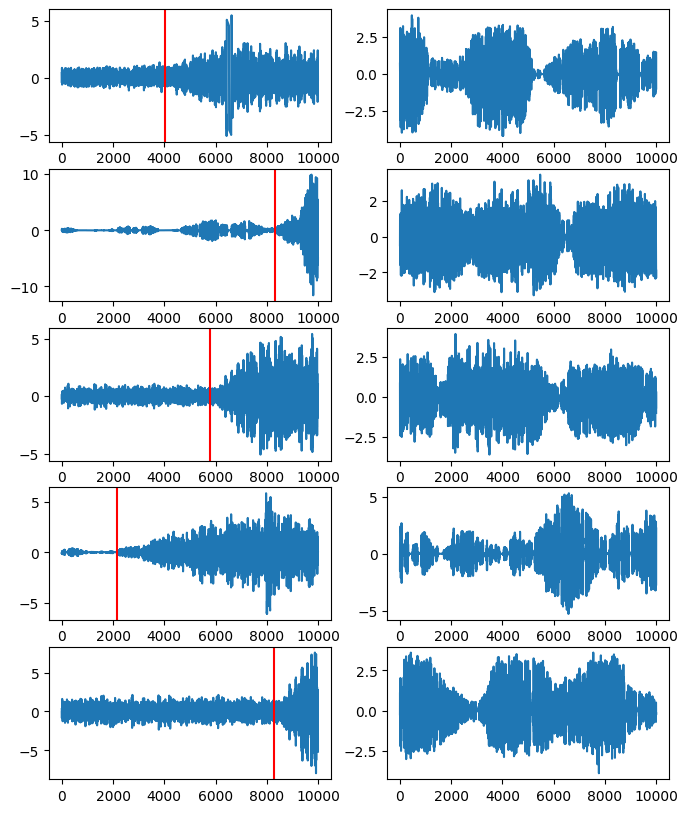

In [166]:



q = QuakeData(downsample_data=True, chunk_data=True, normalize_data=True, window_step_size=500, window_size=10_000, window_deadzone=1000)


l = q.get_train_indices_by_key('lunar')
random.shuffle(l)

pos = []
neg = []

for i in l:
    _, _, has_sample, has_sample_at_all = q.get_train_sample(i)

    if has_sample:
        pos.append(i)
    elif not has_sample_at_all:
        neg.append(i)

fig, ax = plt.subplots(5, 2, figsize=(8, 10))


for i in range(5):
    j = pos[i]
    x_v, label_arr, _, _ = q.get_train_sample(j, return_extra_synthetic_data=True)

    k = label_arr.argmax()

    ax[i, 0].plot(x_v)
    ax[i, 0].axvline(x=k, color='red')

for i in range(5):
    j = neg[i]
    x_v, label_arr, _, _ = q.get_train_sample(j)

    ax[i, 1].plot(x_v)


not found, skipping:  xa.s12.00.mhz.1971-04-13HR00_evid00029 ./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.44it/s]


downsampling from 20.0 to 6.625
23850
downsampling from 20.0 to 6.625
23850
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
downsampling from 20.0 to 6.625
[83970, 83928, 83947, 83954, 83933, 83963, 83922, 83929, 83945, 83944, 83949, 83962, 83965, 83932, 83969, 83941, 83968, 83916, 83939, 83923, 83920, 83960, 83927, 83966, 83942, 83952, 83950, 83953, 83915, 83959, 83948, 83967, 83956, 83951, 83940, 83925, 83958, 83957, 83961, 83934, 83917, 83955, 83935, 83943, 83938, 83926, 83921, 83964, 83924, 83936, 83937, 83919, 83918, 83931, 83930, 83946]


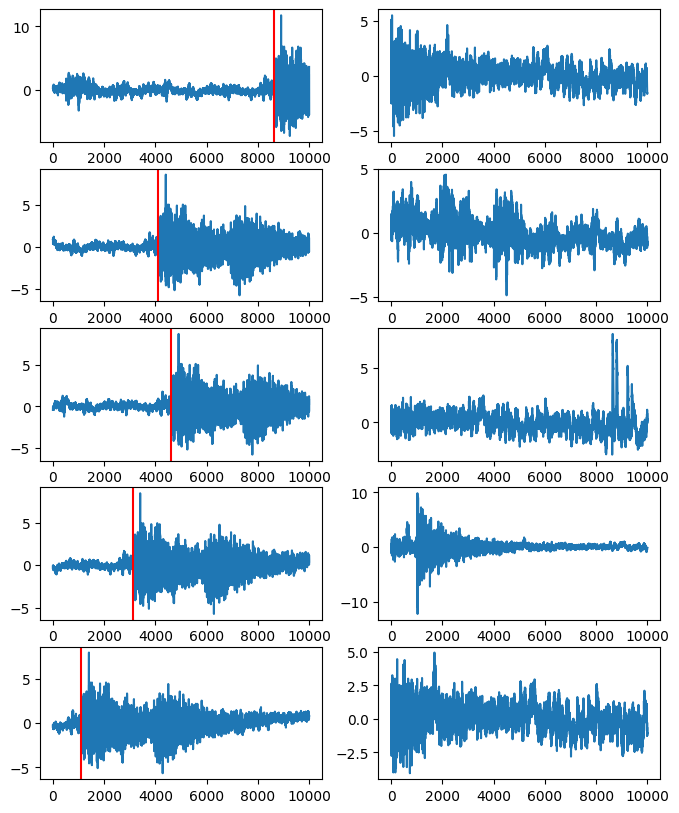

In [170]:


q = QuakeData(downsample_data=True, chunk_data=True, normalize_data=True, window_step_size=500, window_size=10_000, window_deadzone=1000)


l = q.get_train_indices_by_key('mars')
random.shuffle(l)
print(l)

pos = []
neg = []

for i in l:
    _, _, has_sample, has_sample_at_all = q.get_train_sample(i)

    if has_sample:
        pos.append(i)
    elif not has_sample_at_all:
        neg.append(i)


fig, ax = plt.subplots(5, 2, figsize=(8, 10))


for i in range(5):
    j = pos[i]

    if len(pos) <= i:
        break
    
    x_v, label_arr, _, _ = q.get_train_sample(j)

    k = label_arr.argmax()

    ax[i, 0].plot(x_v)
    ax[i, 0].axvline(x=k, color='red')

for i in range(5):
    j = neg[i]
    x_v, label_arr, _, _ = q.get_train_sample(j)

    ax[i, 1].plot(x_v)


not found, skipping:  xa.s12.00.mhz.1971-04-13HR00_evid00029 ./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.18it/s]


23850
23850


100%|█████████████████████████████████████████████████████████████████████████████████| 943/943 [00:27<00:00, 33.93it/s]


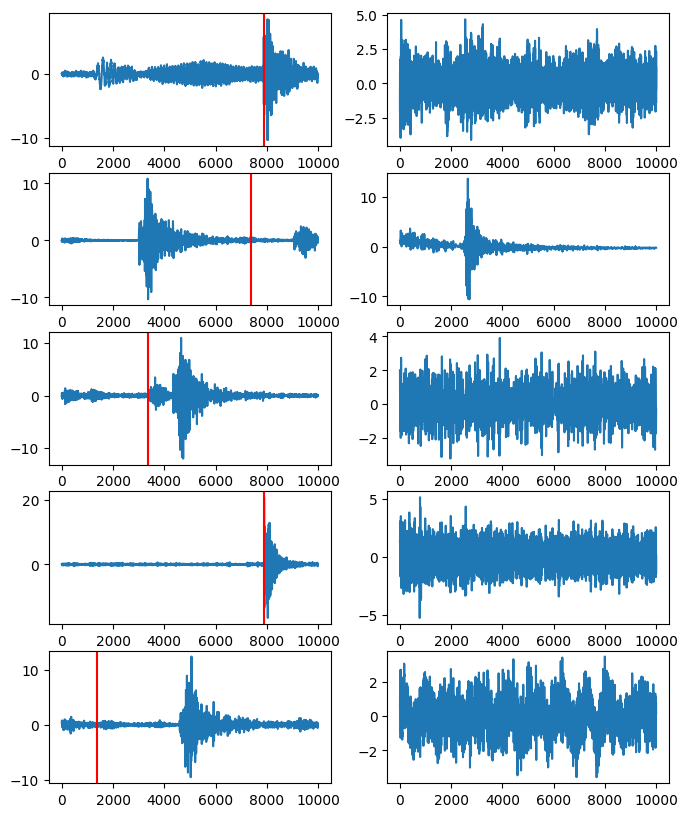

In [209]:



q = QuakeData(downsample_data=True, chunk_data=True, normalize_data=True, window_step_size=500, window_size=10_000, window_deadzone=1000)

l = q.get_train_indices_by_key('earth')
random.shuffle(l)
#print(l)

pos = []
neg = []

for i in l:
    _, _, has_sample, has_sample_at_all = q.get_train_sample(i)

    if has_sample:
        pos.append(i)
    elif not has_sample_at_all:
        neg.append(i)


fig, ax = plt.subplots(5, 2, figsize=(8, 10))


for i in range(5):
    j = pos[i]

    if len(pos) <= i:
        break
    
    x_v, label_arr, _, _ = q.get_train_sample(j)

    k = label_arr.argmax()

    ax[i, 0].plot(x_v)
    ax[i, 0].axvline(x=k, color='red')

for i in range(5):
    j = neg[i]
    x_v, label_arr, _, _ = q.get_train_sample(j)

    ax[i, 1].plot(x_v)



In [207]:


q = QuakeData(downsample_data=True, chunk_data=True, normalize_data=True, window_step_size=500, window_size=10_000, window_deadzone=1000, use_gauss_labels=True)
q.add_synthetic_data(100)

l = q.get_train_indices_by_key('synthetic')
random.shuffle(l)
print(l)

pos = []
neg = []

for i in l:
    _, _, has_sample, has_sample_at_all = q.get_train_sample(i)

    if has_sample:
        pos.append(i)
    elif not has_sample_at_all:
        neg.append(i)


fig, ax = plt.subplots(10, 3, figsize=(8, 10))


for i in range(10):
    j = pos[i]

    if len(pos) <= i:
        break
    
    x_v, label_arr, _, _, x_v_pos, x_v_neg = q.get_train_sample(j, return_extra_synthetic_data=True)

    k = label_arr.argmax()

    ax[i, 0].plot(x_v_neg)
    ax[i, 1].plot(x_v_pos)
    ax[i, 2].plot(x_v)

    ax[i, 1].axvline(x=k, color='red')
    ax[i, 2].axvline(x=k, color='red')


not found, skipping:  xa.s12.00.mhz.1971-04-13HR00_evid00029 ./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.31it/s]


23850
23850


  0%|                                                                                           | 0/100 [00:00<?, ?it/s]


IndexError: list index out of range

In [189]:
j = pos[0]
x = q.get_train_sample(j)

i = x[1].argmax()
print(i)
#list(x[1])

2457
